In [15]:
import arrow
import sys
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import chinese_calendar as calendar

from datetime import datetime
from tensorflow.python.keras.layers import Input, Dense, concatenate
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import LSTM
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.font_manager import FontManager, FontProperties

# 设置全局字体为中文字体
font_path = '/System/Library/Fonts/PingFang.ttc'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

In [16]:
def is_holiday(date):
    """
    判断是否是节假日
    """
    return calendar.is_holiday(date)

# 读取深圳市天气数据
weather_df = pd.read_csv('./data/深圳20230801-20230929天气数据.csv')
weather_df['date'] = pd.to_datetime(weather_df['时间'], utc=True, errors='ignore')
# utc => prc
prc_tz = pytz.timezone('Asia/Shanghai')
weather_df['date_prc'] = weather_df['date'].dt.tz_convert(prc_tz)
# 获取转换后时间的小时数
weather_df['日期'] = weather_df['date_prc'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
weather_df['小时'] = weather_df['date_prc'].dt.hour
weather_df['星期'] = weather_df['date_prc'].dt.weekday + 1
weather_df['是否节假日'] = weather_df['date_prc'].apply(lambda x: is_holiday(x)).astype(int)
weather_df

,城市,时间,温度,体感温度,露点温度,潮湿,降雨,降雨概率,preciptype,下雪,...,uvindex,severerisk,天气现象,icon,date,date_prc,日期,小时,星期,是否节假日
0,shenzhen,2023-07-31T00:00:00,29.0,35.3,25.7,82.30,0.000,0.0,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-07-31 00:00:00+00:00,2023-07-31 08:00:00+08:00,20230731,8,1,0
1,shenzhen,2023-07-31T01:00:00,28.6,33.9,25.2,81.75,0.000,0.0,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-07-31 01:00:00+00:00,2023-07-31 09:00:00+08:00,20230731,9,1,0
2,shenzhen,2023-07-31T02:00:00,26.7,30.2,25.5,93.42,0.506,100.0,rain,0,...,0,10,"Rain, Partially cloudy",rain,2023-07-31 02:00:00+00:00,2023-07-31 10:00:00+08:00,20230731,10,1,0
3,shenzhen,2023-07-31T03:00:00,27.6,32.4,25.6,88.65,0.000,0.0,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-07-31 03:00:00+00:00,2023-07-31 11:00:00+08:00,20230731,11,1,0
4,shenzhen,2023-07-31T04:00:00,27.6,32.1,25.2,86.43,0.000,0.0,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-07-31 04:00:00+00:00,2023-07-31 12:00:00+08:00,20230731,12,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,shenzhen,2023-09-29T19:00:00,27.0,28.1,18.9,61.22,0.000,28.6,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-09-29 19:00:00+00:00,2023-09-30 03:00:00+08:00,20230930,3,6,1
1460,shenzhen,2023-09-29T20:00:00,26.0,26.0,18.6,63.73,0.000,28.6,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-09-29 20:00:00+00:00,2023-09-30 04:00:00+08:00,20230930,4,6,1
1461,shenzhen,2023-09-29T21:00:00,25.7,25.7,18.4,63.94,0.000,38.1,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-09-29 21:00:00+00:00,2023-09-30 05:00:00+08:00,20230930,5,6,1
1462,shenzhen,2023-09-29T22:00:00,25.4,25.4,18.2,64.15,0.000,38.1,NaN,0,...,0,10,Partially cloudy,partly-cloudy-night,2023-09-29 22:00:00+00:00,2023-09-30 06:00:00+08:00,20230930,6,6,1


In [17]:
# 增加台风标识
typhoon_before_hour = typhoon_after_hour = 4
typhoon_map = {
    1: '无台风',
    2: f'台风前{typhoon_before_hour}小时内',
    3: '台风中',
    4: f'台风后{typhoon_after_hour}小时内'
}

# 深圳近期台风时间
typhoon_date = [
   {
       "start_at": (20230901, 11),
       "end_at": (20230903, 24)
   }
]
# TODO: 
weather_df['台风'] = 1

columns = ['日期', '小时', '星期', '是否节假日', '温度', '体感温度', '降雨', '风速', '台风', '可见度']
weather_df = weather_df[columns]
weather_df

,日期,小时,星期,是否节假日,温度,体感温度,降雨,风速,台风,可见度
0,20230731,8,1,0,29.0,35.3,0.000,9.7,1,10.0
1,20230731,9,1,0,28.6,33.9,0.000,11.2,1,10.0
2,20230731,10,1,0,26.7,30.2,0.506,3.8,1,23.9
3,20230731,11,1,0,27.6,32.4,0.000,13.8,1,10.0
4,20230731,12,1,0,27.6,32.1,0.000,9.3,1,9.6
...,...,...,...,...,...,...,...,...,...,...
1459,20230930,3,6,1,27.0,28.1,0.000,15.6,1,24.1
1460,20230930,4,6,1,26.0,26.0,0.000,16.9,1,24.1
1461,20230930,5,6,1,25.7,25.7,0.000,16.4,1,24.1
1462,20230930,6,6,1,25.4,25.4,0.000,16.0,1,24.1


In [22]:
dtype = {
    'city_code': 'str'
}
order_df = pd.read_csv('./data/线上-全部城市-20230913-订单.csv', dtype=dtype)
date_field = 'accepted_at'
order_df = order_df[order_df['city_code'] == '440300']
order_df['date'] = pd.to_datetime(order_df[date_field], format='mixed')  # 将日期转换为时间格式
# 这里不能用shipping_date，是utc时区
# order_df = order_df.rename(columns={'shipping_date': '日期'})
order_df['日期'] = order_df['date'].apply(lambda x: int(x.strftime('%Y%m%d')))
order_df['小时'] = order_df['date'].dt.hour
order_df['星期'] = order_df['date'].dt.weekday
order_df

,shipping_date,city_code,city_name,store_id,store_name,operator_id,operator_name,order_id,seller_order_id,distance,...,created_at,confirmed_at,accepted_at,arrived_at,pickup_at,done_at,date,日期,小时,星期
45,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b79ee51b833a167ab6ae79,田君宁,64c8657267e2ce742b066c2d,64c8657267e2ce742b066c27,3467,...,2023-08-01T09:52:50.881000+08:00,2023-08-01T09:52:50.885000+08:00,2023-08-01T09:52:52.341000+08:00,2023-08-01T09:56:52.528000+08:00,2023-08-01T09:56:57.516000+08:00,2023-08-01T10:31:05.708000+08:00,2023-08-01 09:52:52.341000+08:00,20230801,9,1
46,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b79ee51b833a167ab6ae79,田君宁,64c8666c67e2ce742b066c53,64c8666c67e2ce742b066c4d,2380,...,2023-08-01T09:57:00.163000+08:00,2023-08-01T09:57:00.168000+08:00,2023-08-01T09:57:01.179000+08:00,2023-08-01T09:57:48.157000+08:00,2023-08-01T09:59:31.654000+08:00,2023-08-01T10:16:45.537000+08:00,2023-08-01 09:57:01.179000+08:00,20230801,9,1
47,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c71e80ec5d8f84e32b9344,钟彬,64c8673f67e2ce742b066c82,64c8673f67e2ce742b066c7c,17,...,2023-08-01T10:00:31.516000+08:00,2023-08-01T10:00:31.521000+08:00,2023-08-01T10:00:32.861000+08:00,2023-08-01T10:01:03.557000+08:00,2023-08-01T10:02:28.897000+08:00,2023-08-01T10:04:12.317000+08:00,2023-08-01 10:00:32.861000+08:00,20230801,10,1
48,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c750d82c3f486bbfec6af3,李焜湖,64c868fb67e2ce742b066ca3,64c868fb67e2ce742b066c9d,3691,...,2023-08-01T10:07:55.228000+08:00,2023-08-01T10:07:55.232000+08:00,2023-08-01T10:07:56.616000+08:00,2023-08-01T10:08:09.988000+08:00,2023-08-01T10:10:37.722000+08:00,2023-08-01T10:39:00.270000+08:00,2023-08-01 10:07:56.616000+08:00,20230801,10,1
49,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c71d900f319a4d852ad78f,黄有元,64c86b9267e2ce742b066cc2,64c86b9267e2ce742b066cbc,931,...,2023-08-01T10:18:58.212000+08:00,2023-08-01T10:18:58.216000+08:00,2023-08-01T10:18:59.859000+08:00,2023-08-01T10:19:21.921000+08:00,2023-08-01T10:21:10.476000+08:00,2023-08-01T10:33:50.994000+08:00,2023-08-01 10:18:59.859000+08:00,20230801,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15080,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b8a8c3ba28d89fe44e4f81,方晓邦,65010ee5ca1b6d551e9b7c3c,65010ee5ca1b6d551e9b7c36,788,...,2023-09-13T09:22:45.600000+08:00,2023-09-13T09:22:45.605000+08:00,2023-09-13T09:27:53.293000+08:00,2023-09-13T09:30:57.842000+08:00,2023-09-13T09:37:17.553000+08:00,2023-09-13T09:42:38.661000+08:00,2023-09-13 09:27:53.293000+08:00,20230913,9,2
15081,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c71a7c84aae8413855d884,李赟,6501102bca1b6d551e9b7c5b,6501102bca1b6d551e9b7c55,2264,...,2023-09-13T09:28:11.670000+08:00,2023-09-13T09:28:11.675000+08:00,2023-09-13T09:34:51.302000+08:00,2023-09-13T09:45:32.801000+08:00,2023-09-13T09:45:34.142000+08:00,2023-09-13T10:02:17.598000+08:00,2023-09-13 09:34:51.302000+08:00,20230913,9,2
15082,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b8a8c3ba28d89fe44e4f81,方晓邦,650111aeca1b6d551e9b7c74,650111aeca1b6d551e9b7c6e,723,...,2023-09-13T09:34:38.817000+08:00,2023-09-13T09:34:38.821000+08:00,2023-09-13T09:34:51.348000+08:00,2023-09-13T09:34:59.621000+08:00,2023-09-13T09:37:18.673000+08:00,2023-09-13T09:47:54.796000+08:00,2023-09-13 09:34:51.348000+08:00,20230913,9,2
15083,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64cc67d104d9a5e986f8efdc,赖阳武,6501150fca1b6d551e9b7c98,6501150fca1b6d551e9b7c92,2956,...,2023-09-13T09:49:03.342000+08:00,2023-09-13T09:49:03.346000+08:00,2023-09-13T09:49:04.649000+08:00,2023-09-13T09:53:20.411000+08:00,2023-09-13T10:11:39.768000+08:00,2023-09-13T10:24:28.646000+08:00,2023-09-13 09:49:04.649000+08:00,20230913,9,2


In [34]:
# 按小时统计单量
selected_order_df = order_df[(order_df['日期'] >= 20230802) & (order_df['日期'] < 20230913) ]
order_day_hour_df = selected_order_df.groupby(['日期', '小时']).size().reset_index(name='单量')
order_day_hour_df

,日期,小时,单量
0,20230802,0,24
1,20230802,1,7
2,20230802,2,7
3,20230802,3,4
4,20230802,4,4
...,...,...,...
984,20230912,19,22
985,20230912,20,18
986,20230912,21,25
987,20230912,22,37


In [35]:
order_day_df = order_df.groupby('日期').size().reset_index(name='单量')
order_day_df

,日期,单量
0,20230801,305
1,20230802,331
2,20230803,344
3,20230804,435
4,20230805,411
5,20230806,344
6,20230807,301
7,20230808,311
8,20230809,322
9,20230810,307


In [36]:
# 合并天气数据
df = order_day_hour_df.merge(weather_df, on=['日期', '小时'], how='inner')
df

,日期,小时,单量,星期,是否节假日,温度,体感温度,降雨,风速,台风,可见度
0,20230802,0,24,3,0,30.4,37.0,0.000,11.6,1,10.0
1,20230802,1,7,3,0,32.2,38.5,0.000,7.2,1,28.5
2,20230802,2,7,3,0,30.4,36.4,0.000,11.7,1,10.0
3,20230802,3,4,3,0,29.5,34.5,0.000,11.0,1,10.0
4,20230802,4,4,3,0,28.2,32.9,0.001,3.6,1,29.0
...,...,...,...,...,...,...,...,...,...,...,...
984,20230912,19,22,2,0,29.9,36.9,0.000,13.8,1,31.1
985,20230912,20,18,2,0,30.3,36.3,0.000,10.4,1,10.0
986,20230912,21,25,2,0,30.4,36.9,0.000,11.8,1,10.0
987,20230912,22,37,2,0,30.1,37.9,0.000,7.5,1,33.2


In [37]:
# 选取需要的特征列，并做数据归一化处理
feature_columns = ['小时', '星期', '是否节假日', '温度', '体感温度', '降雨', '风速', '台风', '可见度']
feature_size = len(feature_columns)
predict_column = '单量'
min_max_scaler = MinMaxScaler()
scaled_x = min_max_scaler.fit_transform(df[feature_columns])

standard_scaler = StandardScaler()
scaled_y = standard_scaler.fit_transform(df[[predict_column]])

In [88]:
# keras Model模型
inputs = Input(shape=(feature_size,))
x = Dense(feature_size, activation='sigmoid')(inputs)
x = Dense(feature_size, activation='sigmoid')(x)
outputs = Dense(1, activation='sigmoid')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='mse')

# 训练模型
keras_model.fit(scaled_x, scaled_y, epochs=1000, batch_size=10)

# 评估模型
# loss = keras_model.evaluate(scaled_x, scaled_y)
# loss

Epoch 1/1000
102/102 [==============================] - 0s 911us/step - loss: 1.0936
Epoch 2/1000
102/102 [==============================] - 0s 844us/step - loss: 1.0394
Epoch 3/1000
102/102 [==============================] - 0s 842us/step - loss: 1.0223
Epoch 4/1000
102/102 [==============================] - 0s 831us/step - loss: 1.0142
Epoch 5/1000
102/102 [==============================] - 0s 835us/step - loss: 1.0097
Epoch 6/1000
102/102 [==============================] - 0s 822us/step - loss: 1.0068
Epoch 7/1000
102/102 [==============================] - 0s 861us/step - loss: 1.0048
Epoch 8/1000
102/102 [==============================] - 0s 858us/step - loss: 1.0033
Epoch 9/1000
102/102 [==============================] - 0s 835us/step - loss: 1.0021
Epoch 10/1000
102/102 [==============================] - 0s 885us/step - loss: 1.0012
Epoch 11/1000
102/102 [==============================] - 0s 854us/step - loss: 1.0003
Epoch 12/1000
102/102 [==============================] - 0s 874

In [38]:
train_x = np.reshape(scaled_x, (scaled_x.shape[0], 1, scaled_x.shape[1]))
train_y = np.reshape(scaled_y, (scaled_y.shape[0], 1, scaled_y.shape[1]))

model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(1, feature_size)))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mse', optimizer='nadam')
# 训练模型
model.fit(train_x, train_y, epochs=1000, batch_size=10)

# 评估模型
# loss = model.evaluate(scaled_x, scaled_y)
# loss

Epoch 1/1000
99/99 [==============================] - 5s 3ms/step - loss: 0.9948
Epoch 2/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.9545
Epoch 3/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.8114
Epoch 4/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.5871
Epoch 5/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.5100
Epoch 6/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.4960
Epoch 7/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.4914
Epoch 8/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.4855
Epoch 9/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.4809
Epoch 10/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.4780
Epoch 11/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.4761
Epoch 12/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.4725
Epoch 13/1000
99/99 [====

In [44]:
# 预测结果
predict_df = weather_df[weather_df['日期'] >= 20230801]
predict_data = min_max_scaler.fit_transform(predict_df[feature_columns])
test_x = np.reshape(predict_data, (predict_data.shape[0], 1, predict_data.shape[1]))
predict_result = model.predict(test_x)
predict_result

# 预测结果反归一化
predict_order = standard_scaler.inverse_transform(predict_result)
predict_order
predict_df.loc[:, ['预测单量']] = predict_order
predict_df

,日期,小时,星期,是否节假日,温度,体感温度,降雨,风速,台风,可见度,预测单量
16,20230801,0,2,0,29.6,35.8,0.0,20.9,1,7.6,14.254375
17,20230801,1,2,0,29.2,35.0,0.0,10.9,1,29.0,9.936461
18,20230801,2,2,0,30.4,36.6,0.0,20.1,1,10.0,6.327175
19,20230801,3,2,0,29.5,35.1,0.0,19.5,1,10.0,4.846599
20,20230801,4,2,0,27.7,32.1,0.0,7.4,1,29.0,4.387170
...,...,...,...,...,...,...,...,...,...,...,...
1459,20230930,3,6,1,27.0,28.1,0.0,15.6,1,24.1,5.780272
1460,20230930,4,6,1,26.0,26.0,0.0,16.9,1,24.1,4.828948
1461,20230930,5,6,1,25.7,25.7,0.0,16.4,1,24.1,3.970335
1462,20230930,6,6,1,25.4,25.4,0.0,16.0,1,24.1,3.639850


In [69]:
predict_hour_df = predict_df.merge(order_day_hour_df, how='left', on=['日期', '小时'])
predict_hour_df['单量'] = predict_hour_df['单量'].fillna(0)
predict_hour_df

,日期,小时,星期,是否节假日,温度,体感温度,降雨,风速,台风,可见度,预测单量,单量
1008,20230912,0,2,0,28.3,33.7,0.000,16.6,1,9.7,13.876329,18.0
1009,20230912,1,2,0,27.0,30.6,0.000,7.8,1,16.9,10.002048,9.0
1010,20230912,2,2,0,27.8,32.4,0.000,16.0,1,10.0,6.785413,5.0
1011,20230912,3,2,0,27.4,31.1,0.000,19.6,1,10.0,5.568755,5.0
1012,20230912,4,2,0,25.9,25.9,0.090,7.6,1,28.5,4.765349,9.0
1013,20230912,5,2,0,27.4,30.9,0.000,14.2,1,10.0,3.756226,2.0
1014,20230912,6,2,0,27.4,30.9,0.000,14.2,1,10.0,4.237085,2.0
1015,20230912,7,2,0,25.9,25.9,0.000,7.6,1,31.1,5.228913,6.0
1016,20230912,8,2,0,26.9,30.2,0.000,11.7,1,10.0,8.348626,8.0
1017,20230912,9,2,0,26.9,30.2,0.000,10.7,1,10.0,11.047874,7.0


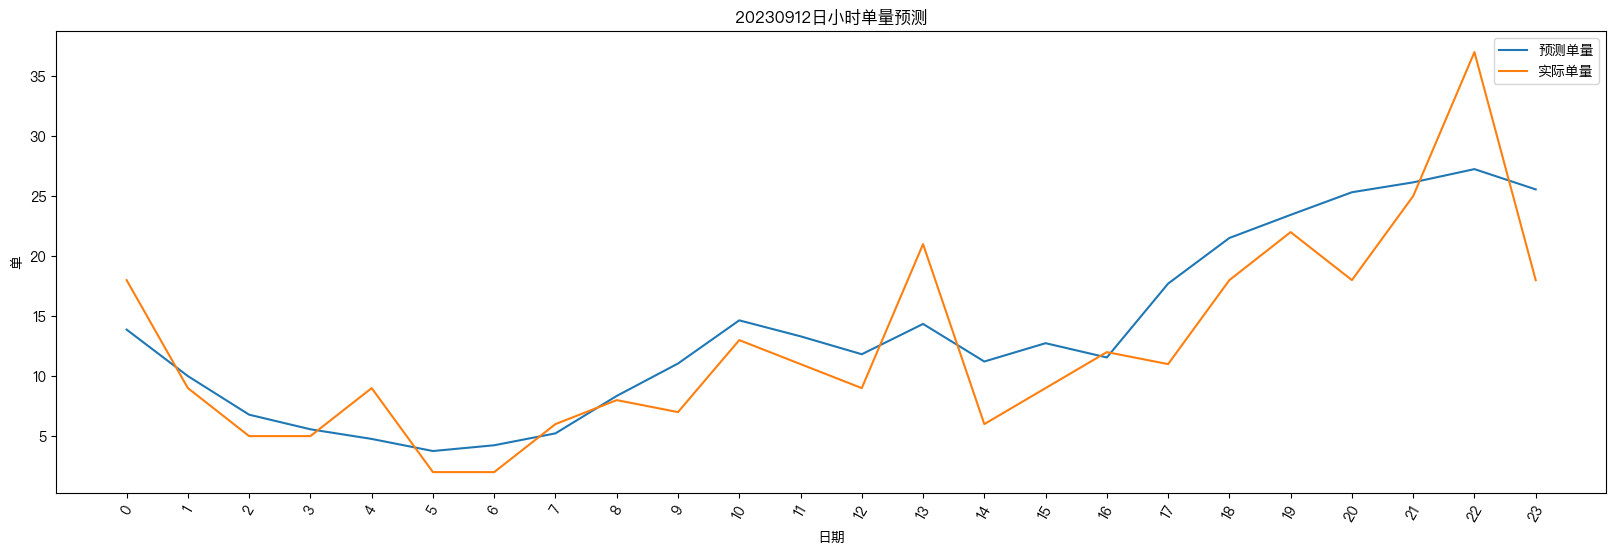

In [71]:
# 创建图形和子图
fig, ax = plt.subplots(figsize=(20, 6))
day = 20230912
predict_hour_df = predict_hour_df[predict_hour_df['日期'] == day]
predict_hour_df['小时'] = predict_hour_df['小时'].astype(str)
ax.plot(predict_hour_df['小时'], predict_hour_df['预测单量'], label='预测单量')
ax.plot(predict_hour_df['小时'], predict_hour_df['单量'], label='实际单量')
ax.legend()
ax.set_title(f'{20230912}日小时单量预测')
ax.set_xlabel('日期')
ax.set_ylabel('单')
plt.xticks(rotation=60)
plt.show()

In [59]:
# 按天合并单量
predict_day_df = predict_df.groupby('日期').agg({"预测单量": 'sum'})
predict_day_df = predict_day_df.merge(order_day_df, how='left', on='日期')
predict_day_df

,日期,预测单量,单量
0,20230801,341.961151,305.0
1,20230802,347.741058,331.0
2,20230803,376.589111,344.0
3,20230804,406.124725,435.0
4,20230805,398.675232,411.0
...,...,...,...
56,20230926,322.972137,NaN
57,20230927,351.821320,NaN
58,20230928,557.888733,NaN
59,20230929,366.606537,NaN


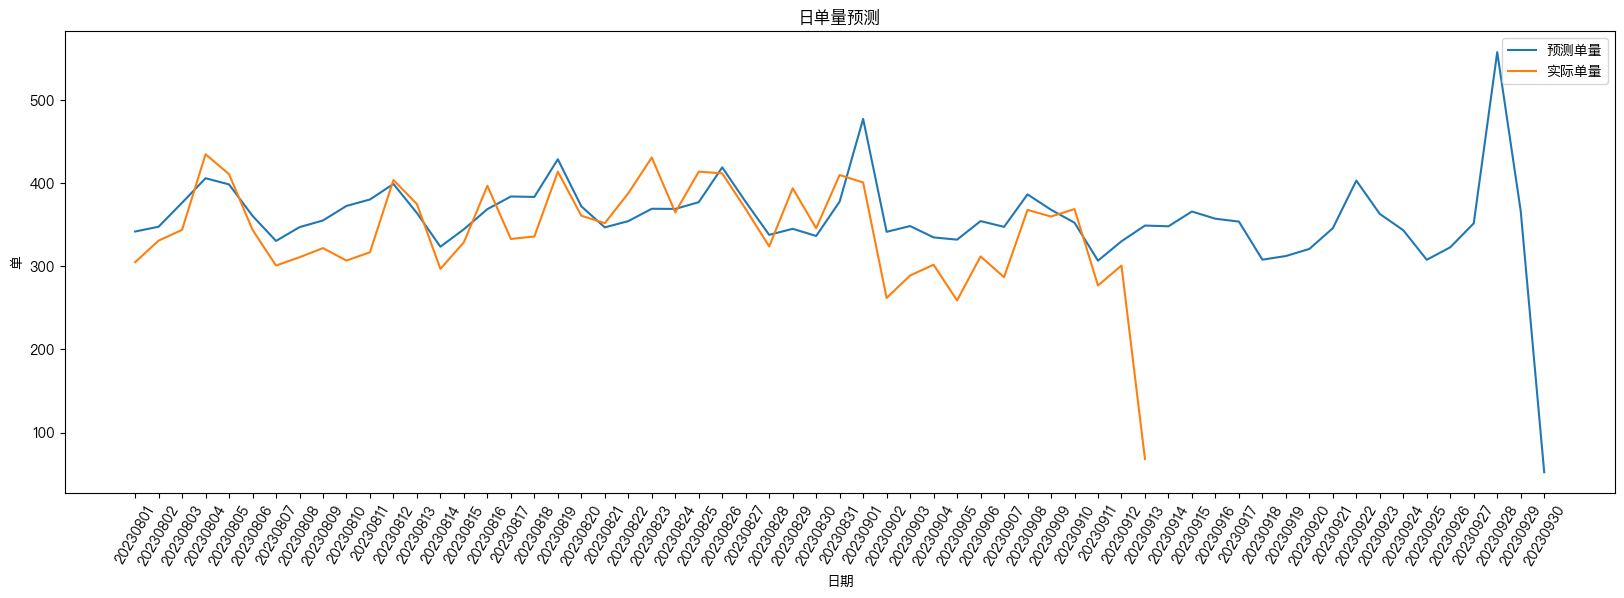

In [66]:
# 创建图形和子图
fig, ax = plt.subplots(figsize=(20, 6))
# 将日期转换为 datetime 对象
# predict_day_df['日期'] = pd.to_datetime(predict_day_df['日期'])
predict_day_df['日期'] = predict_day_df['日期'].astype(str)
ax.plot(predict_day_df['日期'], predict_day_df['预测单量'], label='预测单量')
ax.plot(predict_day_df['日期'], predict_day_df['单量'], label='实际单量')
ax.legend()
ax.set_title('日单量预测')
ax.set_xlabel('日期')
ax.set_ylabel('单')
plt.xticks(rotation=60)
plt.show()